# Identifying Entities in Healthcare Data

**-Shashank Pawaskar(Upgrad Batch : C48)**

#### Introduction
‘BeHealthy’ has a web platform that allows doctors to list their services and manage patient interactions and provides services for patients such as booking interactions with doctors and ordering medicines online. Here, doctors can easily organise appointments, track past medical records and provide e-prescriptions.

So, companies like ‘BeHealthy’ are providing medical services, prescriptions and online consultations and generating huge data day by day.



#### Description
We have been given such a data set in which a lot of text is written related to the medical domain.
- In the dataset, there are a lot of diseases that can be mentioned in the entire dataset and their related treatments are also mentioned implicitly in the text, and its treatment can be identified using the sentence.

- Note that it is not explicitly mentioned in the dataset about the diseases and their treatment, but somehow, we need to build an algorithm to map the diseases and their respective treatment.

- We have been asked to determine the disease name and its probable treatment from the dataset and list it out in the form of a table or a dictionary like this.


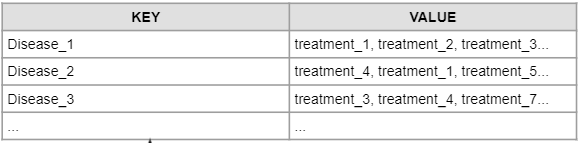

**The ‘train_sent’ dataset, there are a total of 2,599 sentences when you form the sentences from the words.**

**Similarly, there are a total of 1,056 sentences in the ‘test_sent’ dataset when you form the sentences from the words.**

#### Expected Tasks
There are eight major tasks that you need to perform to complete the assignment. They are as follows:
- 1.	Data preprocessing
- 2.	Concept identification
- 3.	Defining the features for CRF
- 4.	Getting the features words and sentences
- 5.	Defining input and target variables
- 6.	Building the model
- 7.	Evaluating the model
- 8.	Identifying the diseases and predicted treatment using a custom NER


## Workspace set up: Import and Install useful packages.

In [1]:
# Installations
!pip install pycrf
!pip install sklearn-crfsuite
# Getting Error - "'CRF' object has no attribute 'keep_tempfiles'" -- Version issue
# Solution Reference - https://github.com/TeamHG-Memex/sklearn-crfsuite/issues/60
!pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Library Imports
import pandas as pd
import re
import spacy
import os
import pathlib
import warnings
import sklearn_crfsuite
warnings.filterwarnings('ignore')

# Import model and metrics
from sklearn_crfsuite import CRF, scorers, metrics

In [3]:
# Spacy Modelto pre-train mode, using Small.
model = spacy.load("en_core_web_sm")

In [4]:
# Class for Print Formatting
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

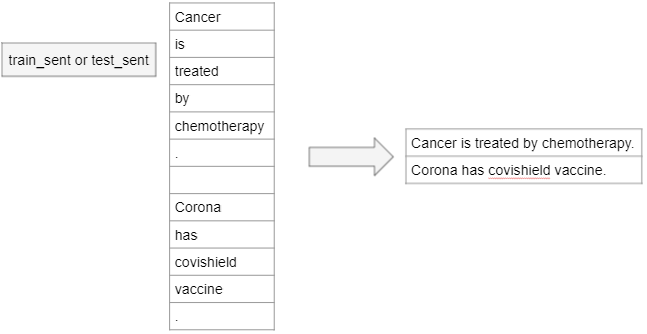

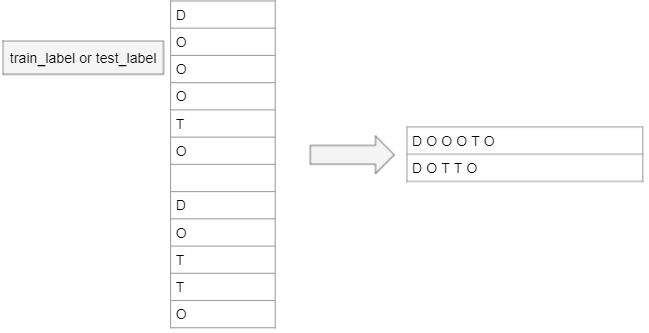

In [5]:
# Reading the train and test data sets
with open('train_sent', 'r') as train_sent_file:
  train_words = train_sent_file.readlines()

with open('train_label', 'r') as train_labels_file:
  train_labels_by_word = train_labels_file.readlines()

with open('test_sent', 'r') as test_sent_file:
  test_words = test_sent_file.readlines()

with open('test_label', 'r') as test_labels_file:
  test_labels_by_word = test_labels_file.readlines()

In [6]:
# Lets' check to see that the number of words and labels and confirm whether they match.
print(color.BLUE+color.BOLD+"Train Dataset\n","No. of words: ",str(len(train_words)),"\n No. of labels: ",str(len(train_labels_by_word))+color.END)
print(color.GREEN+color.BOLD+"\n\nTest Dataset\n","No. of words: ",str(len(test_words)),"\n No. of labels: ",str(len(test_labels_by_word))+color.END)

Train Dataset
 No. of words:  48501 
 No. of labels:  48501


Test Dataset
 No. of words:  19674 
 No. of labels:  19674


#### Lets check type of words (in terms of whether they case lower case, upper case, digits....so on)
#### This will help us in identifying the features to be added

In [7]:
# Lets check type of words (in terms of whether they case lower case, upper case, digits....so on)
# This will help us in identifying the features to be added
def check_words(word_list):
    lower=0
    upper=0
    Init_cap=0
    Init_small=0
    digit=0
    others=0
    for word in word_list:
        if word.islower(): # All letters in the word are in lower case
            lower +=1
        elif word.isupper(): # All letters in the word are in upper case
            upper += 1
        elif word[0].isupper(): # First letter of the word is in Upper case and rest of the word can have mixed case or digits
            # we could have used istitle(), but it does not take case of words with mixed case, e.g. 'LaZy'
            Init_cap += 1
        elif word[0].islower(): # First letter of the word is in Small case and rest of the word can have mixed case or digits
            Init_small += 1
        elif word.isdigit():  # Digits only
            digit += 1
        else:
            others += 1 # All other characters, other than words and digits.
    return lower, upper, Init_cap, Init_small, digit, others

In [8]:
# Lets Check for Train Words
lower, upper, Init_cap, Init_small, digit, others = check_words(train_words)
print(color.BOLD+color.UNDERLINE+color.BLUE+'Train Dataset Words'+color.END)
print(color.BLUE+'No. of Lower case words : '+str(lower))
print('No. of Upper case words : '+str(upper))
print('No. of Words with Initial letter in Upper case : '+str(Init_cap))
print('No. of Words with Initial letter in Small case : '+str(Init_small))
print('No. of Digits : '+str(digit))
print('Other than words or digits : '+str(others))
Total_words = lower + upper + Init_cap + Init_small + digit + others
print('Total Words : '+str(Total_words)+color.END)

Train Dataset Words
No. of Lower case words : 35881
No. of Upper case words : 1315
No. of Words with Initial letter in Upper case : 3305
No. of Words with Initial letter in Small case : 112
No. of Digits : 0
Other than words or digits : 7888
Total Words : 48501


In [9]:
# Lets Check for Test Words
lower, upper, Init_cap, Init_small, digit, others = check_words(test_words)
print(color.BOLD+color.UNDERLINE+color.GREEN+'Test Dataset Words'+color.END)
print(color.GREEN+'No. of Lower case words : '+str(lower))
print('No. of Upper case words : '+str(upper))
print('No. of Words with Initial letter in Upper case : '+str(Init_cap))
print('No. of Words with Initial letter in Small case : '+str(Init_small))
print('No. of Digits : '+str(digit))
print('Other than words or digits : '+str(others))
Total_words = lower + upper + Init_cap + Init_small + digit + others
print('Total Words : '+str(Total_words)+color.END)

Test Dataset Words
No. of Lower case words : 14548
No. of Upper case words : 554
No. of Words with Initial letter in Upper case : 1273
No. of Words with Initial letter in Small case : 38
No. of Digits : 0
Other than words or digits : 3261
Total Words : 19674


In [10]:
# Creating a function to process the file, read the words in each row and return a sentence list.
# Assumption Stated : Blank Row marks the end of the sentence.
def words_to_sentence(input_file):
    i_file = open(input_file, 'r')
    file_name = i_file.readlines()
    i_file.close()

    output_list = []

    full_sentence = ""

    for each_word in file_name:
        each_word = each_word.strip()
        if each_word == "":
            output_list.append(full_sentence) # To append the complete sentence to the output list
            full_sentence = "" # For new sentence start
        else:
            if full_sentence:
                full_sentence += " " + each_word
            else:
                full_sentence = each_word

    return output_list

In [11]:
# Load the data from Files to Train and Test Sentence List
# Data split will be Sentence and Labels.
train_sentences = words_to_sentence('train_sent')
train_labels = words_to_sentence('train_label')
test_sentences = words_to_sentence('test_sent')
test_labels = words_to_sentence('test_label')

In [12]:
# Print first five sentences from the processed dataset
for each_item in range(5):
    print(f"Sentence {each_item+1} is: {train_sentences[each_item]}")
    print(f"Label {each_item+1} is: {train_labels[each_item]}")
    print("-"*100)

Sentence 1 is: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Label 1 is: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
----------------------------------------------------------------------------------------------------
Sentence 2 is: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Label 2 is: O O O O O O O O O O O O O O O O O O O O O O O O O
----------------------------------------------------------------------------------------------------
Sentence 3 is: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Label 3 is: O O O O O O O O O O O O O O O
----------------------------------------------------------------------------------------------------
Sentence 4 is: The `` corrected '' ce

### Count the number of sentences in the processed train and test dataset

In [13]:
# Print the count of sentences for Train and Test
print(color.BOLD+f"Number of Sentences :"+color.END)
print(color.BLUE+f"In Train dataset : {len(train_sentences)}" + color.END)
print(color.GREEN+f"In Test dataset : {len(test_sentences)}" + color.END)

Number of Sentences :
In Train dataset : 2599
In Test dataset : 1056


### Count the number of lines of labels in the processed train and test dataset.

In [14]:
# Print the count of labels for Train and Test.
print(color.BOLD+"Number of Labels :"+color.END)
print(color.BLUE+f"In Train dataset : {len(train_labels)}" +color.END)
print(color.GREEN+f"In Test dataset : {len(test_labels)}" +color.END)

Number of Labels :
In Train dataset : 2599
In Test dataset : 1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [15]:
# Token list of Noun and Proper Noun
tokens_list_noun_propernoun = []
# Lets assign the appropriate tokens which Nouns and Proper Nouns to the above list
for sentences in (train_sentences, test_sentences):
    for sent in sentences:
        processed_sent = model(sent)
        for each_token in processed_sent:
            if each_token.pos_ == "NOUN" or each_token.pos_ == "PROPN":
                tokens_list_noun_propernoun.append(each_token.text)
print(tokens_list_noun_propernoun)

['births', 'weeks', 'University', 'Vermont', 'delivery', 'route', 'indication', 'age', 'parity', 'practice', 'group', 'risk', 'status', 'rate', '%', 'rate', '%', 'presentation', 'indication', '%', 'rate', 'medicine', 'patients', '%', 'rate', '%', 'Arrest', 'dilation', 'indication', 'subgroups', '%', 'rates', 'care', 'hospitals', 'rates', 'community', 'hospitals', 'groups', 'age', 'trimester', 'fluid', 'index', 'AFI', 'fluid', 'status', 'temperature', 'increases', 'decrease', 'AFI', 'June', 'August', 'period', 'heat', 'women', 'singleton', 'pregnancies', 'weeks', 'gestation', 'testing', 'AFI', 'determinations', 'ambient', 'temperature', 'area', 'day', 'mean', 'temperature', 'test', 'date', 'AFI', 'Spearman', 'rank', 'Correlation', 'relationship', 'account', 'AFI', 'measure', 'well', 'being', 'study', 'population', 'women', 'diabetes', 'screening', 'women', 'clinic', 'Hadassah', 'Medical', 'Center', 'year', 'period', 'women', '%', 'treatment', 'weeks', 'group', 'women', '%', 'treatment',

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [16]:
# Store the data in dataframe to hold the tokens which are either NOUN or PROPER NOUN
df_noun_propn = pd.Series(tokens_list_noun_propernoun)

In [17]:
# Getting then count of each token and sorting the data in top 25 most token counts
df_noun_propn.value_counts().sort_values(ascending=False).head(25)

patients        492
treatment       281
%               247
cancer          200
therapy         175
study           154
disease         142
cell            140
lung            116
group            94
chemotherapy     88
gene             87
effects          85
results          79
women            77
use              74
TO_SEE           74
risk             71
cases            71
surgery          71
analysis         70
rate             67
response         66
survival         65
children         64
dtype: int64

## Defining features for CRF





###### Analysis of PoS tags - Independent assignment for words vs Contextual assignment in a sentence.*italicized text*

In [18]:
# Now that we have created the sentences, post tags are correctly captured.
# Choosing a sentence in the Train list of sentences.
sentence = train_sentences[1]
# Split the sentence into constituent words.
sent_list = sentence.split()
# Choosing 3rd word in the sentence.
pos = 2
word = sent_list[pos]        # Extracting word for PoS tag analysis.
print(color.BOLD+"Sentence : "+color.END+ sentence)
# Pos Tag for the individual without taking its context in the sentence
print(color.BOLD+"\nPoS tag of word in isolation Word (without taking into account its context in the sentence) : "+color.END+word+"--"+model(word)[0].pos_)

Sentence : The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )

PoS tag of word in isolation Word (without taking into account its context in the sentence) : cesarean--VERB


In [19]:
# Now lets check whether post tag changes when we consider the same word in context of the sentence.
print(color.BOLD+"\nResult of modified workflow to obtain PoS tag of word at a specific position while keeping context within sentence in-tact."+color.END)
cnt = 0
for token in model(sentence):
      postag = token.pos_
      if (token.text == word) and (cnt == pos):
          break
      cnt += 1
print("Word:", word,"POSTAG:",postag)


Result of modified workflow to obtain PoS tag of word at a specific position while keeping context within sentence in-tact.
Word: cesarean POSTAG: ADJ


**The word post tag changes when we consider its relevance in context of the sentence**

Hence we need to add Feature, where the post tag of the word is set for the word in context of the sentence.

#### We have defined the following features for CRF model building:

- f1 = input word is in lower case;
- f2 = post tag of the word in context of the sentence;
- f3 = last 3 characters of word;
- f4 = last 2 characers of word;
- f5 = 1; if the word is in uppercase, 0 otherwise;
- f6 = 1; if word is a number; otherwise 0
- f7 = 1; if the word starts with a capital letter; otherwise 0
- f8 = 1; if the word starts with a small case letter; otherwise 0
- f1, f2, f5, f6, f7, f8 - Is repeated when previous word is checked in the sentence.

In [20]:
# Let's define the features to get the feature value for one word, using the function we had practiced learning the module.
# Reference - CRF.ipynb
def getFeaturesForOneWord(sentence, pos, pos_tags):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word.pos=' + pos_tags[pos], # Post Tag of the word in context of the sentence
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter, rest of the letters can be mixed case or digits
    'word.startWithSmallCase=%s' % word[0].islower() # is the word starting with a small case letter, rest of the letters can be mixed case or digits
  ]

  #Use the previous word also while defining features
  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
        'prev_word.lower=' + prev_word.lower(),
        'prev_word.pos=' + pos_tags[pos-1],  
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.startsWithSmallCase=%s' % prev_word[0].islower()
    ])
    # **Comented this section, as when used the '"hereditary retinoblastoma' is not selected**
    # Feature of words that are not at end of a sentence
    #if(pos < len(sentence)-1):
    #  word1 = sentence[pos+1]
    #  features.extend([
    #      '+1:word.lower=' + word1.lower(),
    #      '+1:word.istitle=%s' % word1.istitle(),
    #      '+1:word.isupper=%s' % word1.isupper(),
    #      '+1:word.isdigit=%s' % word1.isdigit(),
    #      '+1:w,ord.pos=' + pos_tags[pos+1]])

  # Mark the begining and the end words of a sentence correctly in the form of features.
  if (pos == 0):
    features.append('BEG') # feature to track begin of sentence

  if (pos == len(sentence)):
    features.append('END') # feature to track end of sentence

  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [21]:
# Creating a Function to get features for a sentence, as we did when learning the module.
# Reference - CRF.ipynb
def getFeaturesForOneSentence(sentence):

    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []

    for each_token in processed_sent:
        postags.append(each_token.pos_)

    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [22]:
# Creating a Function to get the labels for a sentence.
# Reference - CRF.ipynb
def getLabelsInListForOneSentence(labels):
  return labels.split()

In [23]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
# Reference - CRF.ipynb
example_sentence = train_sentences[5]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age


['word.lower=at',
 'word.pos=ADP',
 'word[-3:]=at',
 'word[-2:]=at',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.startWithSmallCase=True',
 'prev_word.lower=rates',
 'prev_word.pos=NOUN',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.startsWithSmallCase=True']

In [24]:
# Print the total number of Features applied
print(color.BOLD+color.RED+'Total No. of Featuers Applied for the Model : '+str(len(features))+color.END)

Total No. of Featuers Applied for the Model : 24


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

In [25]:
# Features for Train Dataset
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
# Features for Test Dataset
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

### Define the labels as the target variable for test and the train dataset

In [26]:
# Labels for Train Dataset
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]
# Labels for Test Dataset
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

In [27]:
# Checking - Train and Text Sentences and Labels count
print(color.BOLD+"X Train (Sentences) : "+color.END+str(len(X_train)))
print(color.BOLD+"\nX Test (Sentences) : "+color.END+str(len(X_test)))
print(color.BOLD+"\nY Train (Labels) : "+color.END+str(len(Y_train)))
print(color.BOLD+"\nY Test (Labels) : "+color.END+str(len(Y_test)))

X Train (Sentences) : 2599

X Test (Sentences) : 1056

Y Train (Labels) : 2599

Y Test (Labels) : 1056


## Build the CRF Model

In [28]:
# Build the CRF model.
# Getting Error , so adding "try"
# Solution Reference - https://github.com/TeamHG-Memex/sklearn-crfsuite/issues/60
crf = sklearn_crfsuite.CRF(max_iterations=1000)
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass


## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [29]:
# Predicting the Lables for each taken in every pre-processed sentence of the test dataset
predictions = crf.predict(X_test)
print(len(predictions))

1056


### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [30]:
# Test Data Prediction F1 Score
f1_score = metrics.flat_f1_score(Y_test, predictions, average='weighted')
print(f"F1 score is: {round(f1_score,4)}")

F1 score is: 0.9086


In [31]:
# Print the orginal labels and predicted labels for the sentence  in test data, which is at index value 10.
id = 10
print("Sentence:",test_sentences[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", predictions[id])

Sentence: The most common indication leading to diagnosis was abnormal ultrasound finding ( 48.2 % ) , followed by advanced maternal age ( 44.4 % )
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [32]:
len_test_sent = len(test_sentences)
unmatched=[]
matched = 0
not_matched = 0
for i in range(len_test_sent):
  if (Y_test[i] == predictions[i]):
    matched +=1
  else:
    not_matched+=1
    print(str(i)+" Sentence:",test_sentences[i])
    print("Orig Labels:", Y_test[i])
    print("Pred Labels:", predictions[i])
print(color.BOLD+"Total Predictions Matching the Original Test Dataset :"+str(matched)+color.END)
print(color.BOLD+"Total Predictions Not Matching the Original Test Dataset :"+str(not_matched)+color.END)

5 Sentence: This study tested the hypothesis that to reduce the rate of macrosomic infants in gestational diabetes cases , good glycemic control should be initiated before 34 completed gestational weeks
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
8 Sentence: In our study , we specifically analyzed the role played by advanced maternal age and sonographically discovered abnormalities in the detection of autosomal trisomies
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
9 Sentence: All together , 27 fet

## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

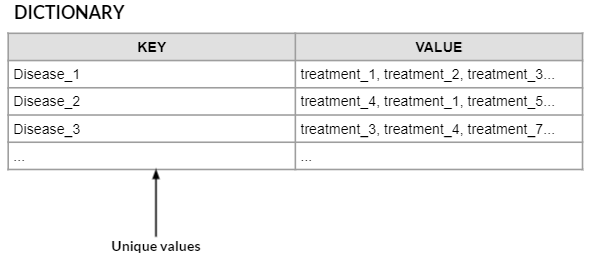

In [33]:
# Extract predicted disease and corresponding treatment in a dictionary, assuming that reach line time will have both Disease and Treatment details
# Initialize an empty dictionary
Disease_Treatment_dict = {}           
cnt_predictions=len(predictions)
for i in range(cnt_predictions):
  # Disease Count
  cnt_disease = 0
  # Treatment Count
  cnt_treatment = 0
  # Disease List
  diseases = [""]
  # Treatment List
  treatment = [""]
  # Get length of the sentence from predictions
  sent_len = len(predictions[i])
  for j in range(sent_len):
    # Check if the label of the current word is D (Disease)
    if (predictions[i][j] == 'D'):
      # Add Disease to the disease list
      diseases[cnt_disease] += (X_test[i][j][0].split('=')[1] + " ")
      # Disease name may span over multiple words
      if j < sent_len - 1:
        # Check for name of disease extending over multiple words.
        if (predictions[i][j+1] != 'D'):
          # Here the next word is also tagged as D (Disease)
          diseases[cnt_disease] = diseases[cnt_disease][:-1]
          cnt_disease += 1
          diseases.append("")
      else:
        diseases[cnt_disease] = diseases[cnt_disease][:-1]
        cnt_disease += 1
        diseases.append("")
    # Check if the label of the current word is T (Treatment)
    if (predictions[i][j] == 'T'):
      treatment[cnt_treatment] += (X_test[i][j][0].split('=')[1] + " ") # Adding word to corresponding treatment list.
      # Similar to Disease, Treatment may span across multiple words
      if j < sent_len - 1:
        # Check if the next weod is also tagged as T (Treatment)
        if (predictions[i][j+1] != 'T'):
          # Here the next word is also tagged as T (Treatment)
          treatment[cnt_treatment] = treatment[cnt_treatment][:-1]
          cnt_treatment += 1
          treatment.append("")
      else:
        treatment[cnt_treatment] = treatment[cnt_treatment][:-1]
        cnt_treatment += 1
        treatment.append("")
  # Remove the empty placeholder
  diseases.pop(-1)
  treatment.pop(-1)
  # Now we add Diseases and Append corresponding Treatment and store them in our dictionary
  # First check if the current sentence has any disease/s tagged.
  if len(diseases) > 0:
    # if Yes, then we iterate for diseases
    for disease in diseases:
      # Check if there dictionary already has disease added
      if disease in Disease_Treatment_dict.keys():
        # Append treatment, as there is / are treatment/s already existing  for the particular disease
        Disease_Treatment_dict[disease].extend(treatment)
      else:
        # Else we add the list of treatments for particular disease.
        Disease_Treatment_dict[disease] = treatment

In [34]:
# We notice that there are some Diseases for which there is no treatment mentioned, we will remove that data from the dictionary
final_dict = {}
for key in Disease_Treatment_dict.keys():
    if Disease_Treatment_dict[key] != []:
        final_dict[key] = Disease_Treatment_dict[key]

In [35]:
# List the cleaned dictionary
final_dict

{'breast cancer': ['hormone replacement therapy',
  'undergone subcutaneous mastectomy'],
 'ovarian cancer': ['hormone replacement therapy',
  'undergone subcutaneous mastectomy'],
 'prostate cancer': ['radical prostatectomy and iodine 125 interstitial radiotherapy'],
 'mutated prostate cancer': ['radical prostatectomy and iodine 125 interstitial radiotherapy'],
 'hereditary retinoblastoma': ['radiotherapy'],
 'unstable angina or non-q-wave myocardial infarction': ['roxithromycin'],
 'coronary-artery disease': ['antichlamydial antibiotics'],
 'primary pulmonary hypertension ( pph )': ['fenfluramines'],
 'foot infection': ['g-csf treatment'],
 "early parkinson 's disease": ['ropinirole monotherapy'],
 'sore throat': ['antibiotics'],
 'abdominal tuberculosis': ['steroids'],
 "crohn 's disease": ['steroids'],
 'female stress urinary incontinence': ['surgical treatment'],
 'stress urinary incontinence': ['therapy'],
 'preeclampsia ( proteinuric hypertension )': ['intrauterine insemination 

### Predict the treatment for the disease name: 'hereditary retinoblastoma'\

In [36]:
# Create a function to display the disease
def predict_treatment(s_dict, disease_s=""):
  ret_string = []
  # search dictionary
  if disease_s != "":
    ret_string = "Treatments for '"+format(disease_s) + "' is/are : "
    dis_treatment = s_dict[disease_s]
    ret_string = ret_string + format(dis_treatment)
  else:
    len_disease=len(s_dict.keys())
    #print(len_disease)
    i=0
    for disease in s_dict.keys():
      dis_treatment=s_dict[disease]
      #print(disease)
      #print(dis_treatment)
      str_1 = str(i)+" Treatments for '"+format(disease) + "' is/are : "+format(dis_treatment)
      ret_string.insert(i, str_1)
      if (i != len_disease):
        i+=1
  return ret_string

In [37]:
# Print Treatment for  "hereditary retinoblastoma"
result = predict_treatment(final_dict,"hereditary retinoblastoma")
print(result)

Treatments for 'hereditary retinoblastoma' is/are : ['radiotherapy']


In [38]:
# Print Treatment for  "prostate cancer"
result = predict_treatment(final_dict,"prostate cancer")
print(result)

Treatments for 'prostate cancer' is/are : ['radical prostatectomy and iodine 125 interstitial radiotherapy']


In [39]:
# Print Treatments for all Diseases
result = predict_treatment(final_dict)
for strg in result:
  print(strg)

0 Treatments for 'breast cancer' is/are : ['hormone replacement therapy', 'undergone subcutaneous mastectomy']
1 Treatments for 'ovarian cancer' is/are : ['hormone replacement therapy', 'undergone subcutaneous mastectomy']
2 Treatments for 'prostate cancer' is/are : ['radical prostatectomy and iodine 125 interstitial radiotherapy']
3 Treatments for 'mutated prostate cancer' is/are : ['radical prostatectomy and iodine 125 interstitial radiotherapy']
4 Treatments for 'hereditary retinoblastoma' is/are : ['radiotherapy']
5 Treatments for 'unstable angina or non-q-wave myocardial infarction' is/are : ['roxithromycin']
6 Treatments for 'coronary-artery disease' is/are : ['antichlamydial antibiotics']
7 Treatments for 'primary pulmonary hypertension ( pph )' is/are : ['fenfluramines']
8 Treatments for 'foot infection' is/are : ['g-csf treatment']
9 Treatments for 'early parkinson 's disease' is/are : ['ropinirole monotherapy']
10 Treatments for 'sore throat' is/are : ['antibiotics']
11 Treat

In [40]:
# Lets create a dataframe, to view the dictionary in proper tabular format
pd.set_option('display.max_rows', None)
df_disease_treatment = pd.DataFrame(list(final_dict.items()),columns = ['Key Disease', 'Treatments'])
df_disease_treatment

,Key Disease,Treatments
0,breast cancer,"[hormone replacement therapy, undergone subcut..."
1,ovarian cancer,"[hormone replacement therapy, undergone subcut..."
2,prostate cancer,[radical prostatectomy and iodine 125 intersti...
3,mutated prostate cancer,[radical prostatectomy and iodine 125 intersti...
4,hereditary retinoblastoma,[radiotherapy]
5,unstable angina or non-q-wave myocardial infar...,[roxithromycin]
6,coronary-artery disease,[antichlamydial antibiotics]
7,primary pulmonary hypertension ( pph ),[fenfluramines]
8,foot infection,[g-csf treatment]
9,early parkinson 's disease,[ropinirole monotherapy]


**Summary:**
- The Observed that model Accuracy (F1) Score is 90.86%
- The dictionary has been created and published in Tabular format as expected.
    - Which include 122 unique 'Diseases' and their corresponding 'Treatment'.
**Following are the activities completed to arrive at the above **

**Task - 1**
- Constructed proper sentences from individual words and printed five sentences
    - Correctly counted and matched the number of **sentences** and **labels** in the processed train and test datasets. with the specified number of sentences mentioned in the Assignment.

**Task - 2**
- Used a toolkit like spaCy to extract those tokens that have NOUN or PROPN as their PoS tag and found their frequency from the entire dataset that comprises both the train and the test datasets
    - Printed the top 25 most common tokens with NOUN or PROPN PoS tags for the entire dataset that comprises both the train and the test datasets

**Task - 3**
- Defined the features with the PoS tag as one of the features
    - While defining the features, used the PoS tags and considered the preceding word of the current word. 
    - Used of the previous word’s information makes the CRF model more accurate and exhaustive
    - Marked the beginning and end words of a sentence correctly in the form of features

**Task - 4**
- Written the code to compute the features' value of a sentence
- Written the code to get a list of labels of a given preprocessed label line that you have created earlier

**Task - 5**
- Extracted the **features' values and lables** for each sentence as an input variable for the CRF model in the test and the train datasets

**Task - 6**
- Built the CRF model for a custom NER application

**Task - 7**
- Predicted the labels of each of the tokens in each sentence of the test dataset that has been preprocessed earlier
    - Printed the same
    - Also, printed the Matched and Un-Matched lables, to evaluate the prediction.
- Calculated the f1 score using the actual and the predicted labels of the test dataset

**Task - 8**
- Created the code or logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset
- Predicted the treatment for the disease named 'hereditary retinoblastoma' and 'prostate cancer'


#### References used during the Assignment
- https://learn.upgrad.com/course/3615/segment/40178/237474/725453/3661220
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6528438/
- https://towardsdatascience.com/clinical-named-entity-recognition-using-spacy-5ae9c002e86f
- https://medium.com/@sowmyavivek/named-entity-recognition-ner-to-extract-enrich-content-from-the-healthcare-ecosystem-a5adcc7f7e2d
- https://www.analyticsvidhya.com/blog/2021/04/a-guide-to-feature-engineering-in-nlp/
- https://www.analyticsvidhya.com/blog/2018/08/nlp-guide-conditional-random-fields-text-classification/

# END